In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pwd
os.chdir('/content/drive/My Drive/Colab Notebooks/WeaponProject/Code')
!pwd

/content
/content/drive/My Drive/Colab Notebooks/WeaponProject/Code


In [3]:
import colorsys
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import random 
import json
import re

from keras import backend as K
from keras.models import Model, load_model
from keras.layers import Input

Using TensorFlow backend.


In [4]:
#anchors=[[300,66,333,279,372,362],[163,272,242,130,299,191],[51,43,78, 218,116,84 ]]
#num_anchors=9
class_names =["Handgun","Knife","Rifle"]
num_classes = len(class_names)

loaded_model='/content/drive/My Drive/Colab Notebooks/WeaponProject/Models/Custom_Yolo.h5'
json_path="/content/drive/My Drive/Colab Notebooks/WeaponProject/Models/detection_config.json"

In [ ]:
 model = load_model(l, compile=False)

In [ ]:
print(len(model.layers))

252


In [5]:
class CustomObjectDetection:
    def __init__(self):
        self.__model_type = ""
        self.__model_path = ""
        self.__model_labels = []
        self.__model_anchors = []
        self.__detection_config_json_path = ""
        self.__input_size = 416
        self.__object_threshold = 0.4
        self.__nms_threshold = 0.4
        self.__model = None
        self.__detection_utils = CustomDetectionUtils(labels=[])

    def setModelTypeAsYOLOv3(self):

        self.__model_type = "yolov3"

    def setModelPath(self, detection_model_path):

        self.__model_path = detection_model_path

    def setJsonPath(self, configuration_json):
        
        self.__detection_config_json_path = configuration_json

    def loadModel(self):

        if self.__model_type == "yolov3":
            detection_model_json = json.load(open(self.__detection_config_json_path))

            self.__model_labels = detection_model_json["labels"]
            self.__model_anchors = detection_model_json["anchors"]

            self.__detection_utils = CustomDetectionUtils(labels=self.__model_labels)

            self.__model = yolo_main(Input(shape=(None, None, 3)), 3, len(self.__model_labels))

            self.__model.load_weights(self.__model_path)

    def detectObjectsFromImage(self, input_image="", output_image_path="", input_type="file", output_type="file",
                               extract_detected_objects=False, minimum_percentage_probability=50, nms_treshold=0.4,
                               display_percentage_probability=True, display_object_name=True, thread_safe=False):

        if self.__model is None:
            raise ValueError("You must call the loadModel() function before making object detection.")
        else:
            if output_type == "file":
                output_image_folder, n_subs = re.subn(r'\.(?:jpe?g|png|tif|webp|PPM|PGM)$', '', output_image_path, flags=re.I)
                if n_subs == 0:
                    raise ValueError("output_image_path must be the path where to write the image. "
                                     "Therefore it must end as one the following: "
                                     "'.jpg', '.png', '.tif', '.webp', '.PPM', '.PGM'. {} found".format(output_image_path))
                elif extract_detected_objects:
                    # Results must be written as files and need to extract detected objects as images,
                    # let's create a folder to store the object's images
                    objects_dir = output_image_folder + "-objects"

                    os.makedirs(objects_dir, exist_ok=True)

            self.__object_threshold = minimum_percentage_probability / 100
            self.__nms_threshold = nms_treshold

            output_objects_array = []
            detected_objects_image_array = []

            if input_type == "file":
                image = cv2.imread(input_image)
            elif input_type == "array":
                image = input_image
            else:
                raise ValueError("input_type must be 'file' or 'array'. {} found".format(input_type))

            image_frame = image.copy()

            height, width, channels = image.shape

            image = cv2.resize(image, (self.__input_size, self.__input_size))

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            image = image.astype("float32") / 255.

            # expand the image to batch
            image = np.expand_dims(image, 0)

            if self.__model_type == "yolov3":
                if thread_safe == True:
                    with K.get_session().graph.as_default():
                        yolo_results = self.__model.predict(image)
                else:
                    yolo_results = self.__model.predict(image)

                boxes = list()

                for idx, result in enumerate(yolo_results):
                    box_set = self.__detection_utils.decode_netout(result[0], self.__model_anchors[idx],
                                                                   self.__object_threshold, self.__input_size,
                                                                   self.__input_size)
                    boxes += box_set

                self.__detection_utils.correct_yolo_boxes(boxes, height, width, self.__input_size, self.__input_size)

                self.__detection_utils.do_nms(boxes, self.__nms_threshold)

                all_boxes, all_labels, all_scores = self.__detection_utils.get_boxes(boxes, self.__model_labels,
                                                                                     self.__object_threshold)

                for object_box, object_label, object_score in zip(all_boxes, all_labels, all_scores):
                    each_object_details = dict()
                    each_object_details["name"] = object_label
                    each_object_details["percentage_probability"] = object_score

                    if object_box.xmin < 0:
                        object_box.xmin = 0
                    if object_box.ymin < 0:
                        object_box.ymin = 0

                    each_object_details["box_points"] = [object_box.xmin, object_box.ymin, object_box.xmax, object_box.ymax]
                    output_objects_array.append(each_object_details)

                drawn_image = self.__detection_utils.draw_boxes_and_caption(image_frame.copy(), all_boxes, all_labels,
                                                                            all_scores, show_names=display_object_name,
                                                                            show_percentage=display_percentage_probability)

                if extract_detected_objects:

                    for cnt, each_object in enumerate(output_objects_array):

                        splitted_image = image_frame[each_object["box_points"][1]:each_object["box_points"][3],
                                                     each_object["box_points"][0]:each_object["box_points"][2]]
                        if output_type == "file":
                            splitted_image_path = os.path.join(objects_dir, "{}-{:05d}.jpg".format(each_object["name"],
                                                                                                   cnt))

                            cv2.imwrite(splitted_image_path, splitted_image)
                            detected_objects_image_array.append(splitted_image_path)
                        elif output_type == "array":
                            detected_objects_image_array.append(splitted_image.copy())

                if output_type == "file":
                    cv2.imwrite(output_image_path, drawn_image)

                if extract_detected_objects:
                    if output_type == "file":
                        return output_objects_array, detected_objects_image_array
                    elif output_type == "array":
                        return drawn_image, output_objects_array, detected_objects_image_array

                else:
                    if output_type == "file":
                        return output_objects_array
                    elif output_type == "array":
                        return drawn_image, output_objects_array

In [6]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness=None, classes=None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)

        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]

        return self.score


class CustomDetectionUtils:
    def __init__(self, labels):
        self.__labels = labels
        self.__colors = []

        for i in range(len(labels)):
            color_space_values = np.random.randint(50, 255, size=(3,))
            red, green, blue = color_space_values
            red, green, blue = int(red), int(green), int(blue)
            self.__colors.append([red, green, blue])

    @staticmethod
    def _sigmoid(x):
        return 1. / (1. + np.exp(-x))

    def decode_netout(self, netout, anchors, obj_thresh, net_h, net_w):
        grid_h, grid_w = netout.shape[:2]
        nb_box = 3
        netout = netout.reshape((grid_h, grid_w, nb_box, -1))
        nb_class = netout.shape[-1] - 5
        boxes = []
        netout[..., :2] = self._sigmoid(netout[..., :2])
        netout[..., 4:] = self._sigmoid(netout[..., 4:])
        netout[..., 5:] = netout[..., 4][..., np.newaxis] * netout[..., 5:]
        netout[..., 5:] *= netout[..., 5:] > obj_thresh

        for row in range(grid_h):
            for col in range(grid_w):
                for b in range(nb_box):
                    # 4th element is objectness score
                    objectness = netout[row, col, b, 4]

                    if objectness <= obj_thresh:
                        continue

                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout[row, col, b, :4]
                    x = (col + x) / grid_w  # center position, unit: image width
                    y = (row + y) / grid_h  # center position, unit: image height
                    w = anchors[2 * b + 0] * np.exp(w) / net_w  # unit: image width
                    h = anchors[2 * b + 1] * np.exp(h) / net_h  # unit: image height
                    # last elements are class probabilities
                    classes = netout[row, col, b, 5:]
                    box = BoundBox(x - w / 2, y - h / 2, x + w / 2, y + h / 2, objectness, classes)
                    boxes.append(box)

        return boxes

    @staticmethod
    def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
        new_w, new_h = net_w, net_h
        for i in range(len(boxes)):
            x_offset, x_scale = (net_w - new_w) / 2. / net_w, float(new_w) / net_w
            y_offset, y_scale = (net_h - new_h) / 2. / net_h, float(new_h) / net_h
            boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
            boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
            boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
            boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

    def _interval_overlap(self, interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2, x4) - x1
        else:
            if x2 < x3:
                return 0
            else:
                return min(x2, x4) - x3

    def bbox_iou(self, box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
        intersect = intersect_w * intersect_h
        w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
        w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin
        union = w1 * h1 + w2 * h2 - intersect

        try:
            result = float(intersect) / float(union)
            return result
        except:
            return 0.0

    def do_nms(self, boxes, nms_thresh):
        if len(boxes) > 0:
            nb_class = len(boxes[0].classes)
        else:
            return

        for c in range(nb_class):
            sorted_indices = np.argsort([-box.classes[c] for box in boxes])

            for i in range(len(sorted_indices)):
                index_i = sorted_indices[i]

                if boxes[index_i].classes[c] == 0: continue

                for j in range(i + 1, len(sorted_indices)):
                    index_j = sorted_indices[j]

                    if self.bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                        boxes[index_j].classes[c] = 0

    def get_boxes(self, boxes, labels, thresh):
        v_boxes, v_labels, v_scores = list(), list(), list()
        # enumerate all boxes
        for box in boxes:
            # enumerate all possible labels
            for i in range(len(labels)):
                # check if the threshold for this label is high enough
                if box.classes[i] > thresh:
                    v_boxes.append(box)
                    v_labels.append(labels[i])
                    v_scores.append(box.classes[i] * 100)
                # don't break, many labels may trigger for one box
        return v_boxes, v_labels, v_scores

    def label_color(self, label):
        if label < len(self.__colors):
            return self.__colors[label]
        else:
            return 0, 255, 0

    def draw_boxes_and_caption(self, image_frame, v_boxes, v_labels, v_scores, show_names=False, show_percentage=False):

        for i in range(len(v_boxes)):
            box = v_boxes[i]
            y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
            width, height = x2 - x1, y2 - y1
            class_color = self.label_color(self.__labels.index(v_labels[i]))

            image_frame = cv2.rectangle(image_frame, (x1, y1), (x2, y2), class_color, 2)

            label = ""
            if show_names and show_percentage:
                label = "%s : %.3f" % (v_labels[i], v_scores[i])
            elif show_names:
                label = "%s" % (v_labels[i])
            elif show_percentage:
                label = "%.3f" % (v_scores[i])

            if show_names or show_percentage:
                b = np.array([x1, y1, x2, y2]).astype(int)
                cv2.putText(image_frame, label, (b[0], b[1] - 10), cv2.FONT_HERSHEY_TRIPLEX, 2, (50, 255, 255), 5)
                #cv2.putText(image_frame, label, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 3, (255, 255, 255), 3)

        return image_frame

In [7]:
from functools import wraps

import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Conv2D, MaxPool2D, Add, ZeroPadding2D, UpSampling2D, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.models import Model, Input

def NetworkConv2D_BN_Leaky(input, channels, kernel_size, kernel_regularizer = l2(5e-4), strides=(1,1), padding="same", use_bias=False):

    network = Conv2D( filters=channels, kernel_size=kernel_size, strides=strides, padding=padding, kernel_regularizer=kernel_regularizer, use_bias=use_bias)(input)
    network = BatchNormalization()(network)
    network = LeakyReLU(alpha=0.1)(network)
    return network

def residual_block(input, channels, num_blocks):
    network = ZeroPadding2D(((1,0), (1,0)))(input)
    network = NetworkConv2D_BN_Leaky(input=network,channels=channels, kernel_size=(3,3), strides=(2,2), padding="valid")

    for blocks in range(num_blocks):
        network_1 = NetworkConv2D_BN_Leaky(input=network, channels= channels // 2, kernel_size=(1,1))
        network_1 = NetworkConv2D_BN_Leaky(input=network_1,channels= channels, kernel_size=(3,3))

        network = Add()([network, network_1])
    return network

def darknet(input):
    network = NetworkConv2D_BN_Leaky(input=input, channels=32, kernel_size=(3,3))
    network = residual_block(input=network, channels=64, num_blocks=1)
    network = residual_block(input=network, channels=128, num_blocks=2)
    network = residual_block(input=network, channels=256, num_blocks=8)
    network = residual_block(input=network, channels=512, num_blocks=8)
    network = residual_block(input=network, channels=1024, num_blocks=4)


    return network

def last_layers(input, channels_in, channels_out, layer_name=""):

    network = NetworkConv2D_BN_Leaky( input=input, channels=channels_in, kernel_size=(1,1))
    network = NetworkConv2D_BN_Leaky(input=network, channels= (channels_in * 2) , kernel_size=(3, 3))
    network = NetworkConv2D_BN_Leaky(input=network, channels=channels_in, kernel_size=(1, 1))
    network = NetworkConv2D_BN_Leaky(input=network, channels=(channels_in * 2), kernel_size=(3, 3))
    network = NetworkConv2D_BN_Leaky(input=network, channels=channels_in, kernel_size=(1, 1))

    network_1 = NetworkConv2D_BN_Leaky(input=network, channels=(channels_in * 2), kernel_size=(3, 3))
    network_1 = Conv2D(filters=channels_out, kernel_size=(1,1), name=layer_name)(network_1)

    return  network, network_1

def yolo_main(input, num_anchors, num_classes):

    darknet_network = Model(input, darknet(input))

    network, network_1 = last_layers(darknet_network.output, 512, num_anchors * (num_classes + 5), layer_name="last1")

    network = NetworkConv2D_BN_Leaky( input=network, channels=256, kernel_size=(1,1))
    network = UpSampling2D(2)(network)
    network = Concatenate()([network, darknet_network.layers[152].output])

    network, network_2 = last_layers(network,  256,  num_anchors * (num_classes + 5), layer_name="last2")

    network = NetworkConv2D_BN_Leaky(input=network, channels=128, kernel_size=(1, 1))
    network = UpSampling2D(2)(network)
    network = Concatenate()([network, darknet_network.layers[92].output])

    network, network_3 = last_layers(network, 128, num_anchors * (num_classes + 5), layer_name="last3")

    return Model(input, [network_1, network_2, network_3])

In [ ]:
input_image1='/content/drive/My Drive/Colab Notebooks/testt/Copie de weapon1.jpg'
input_image2='/content/drive/My Drive/Colab Notebooks/testt/Copie de weapon3.jpg'
input_image3='/content/drive/My Drive/Colab Notebooks/testt/Copie de weapon5.jpg'
input_image4='/content/drive/My Drive/Colab Notebooks/testt/1dbc0b2e1bb52d73.jpg'

(-0.5, 1099.5, 549.5, -0.5)

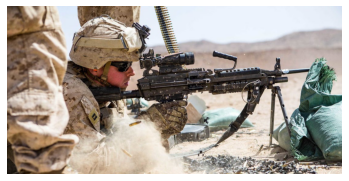

In [ ]:
img = plt.imread(input_image1)
plt.imshow(img)
plt.axis("off")

In [ ]:
output_image_path1="/content/drive/My Drive/Colab Notebooks/WeaponProject/Outputs/r.jpg"
output_image_path2="/content/drive/My Drive/Colab Notebooks/WeaponProject/Outputs/i.jpg"
output_image_path3="/content/drive/My Drive/Colab Notebooks/WeaponProject/Outputs/u.jpg"
output_image_path4="/content/drive/My Drive/Colab Notebooks/WeaponProject/Outputs/x.jpg"

In [ ]:
detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
detector.setModelPath(loaded_model)
detector.setJsonPath(json_path)
detector.loadModel()

In [ ]:
detections = detector.detectObjectsFromImage(input_image4, output_image_path4,minimum_percentage_probability=80,nms_treshold=0.3)
for detection in detections:
    print(detection["name"], " : ", detection["percentage_probability"], " : ", detection["box_points"])

(-0.5, 1099.5, 549.5, -0.5)

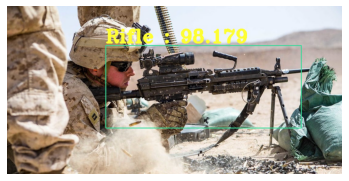

In [ ]:
image1 = plt.imread(output_image_path1)
plt.imshow(image1)
plt.axis("off")

This is the object detection class for videos and camera live stream inputs 

In [8]:
class CustomVideoObjectDetection:

    def __init__(self):
        self.__model_type = ""
        self.__model_path = ""
        self.__model_labels = []
        self.__model_anchors = []
        self.__detection_config_json_path = ""
        self.__model_loaded = False
        self.__input_size = 416
        self.__object_threshold = 0.4
        self.__nms_threshold = 0.4
        self.__detector = []
        self.__detection_utils = CustomDetectionUtils(labels=[])

    def setModelTypeAsYOLOv3(self):
        self.__model_type = "yolov3"
        
    def setModelPath(self, detection_model_path):

        self.__model_path = detection_model_path


    def setJsonPath(self, configuration_json):

        self.__detection_config_json_path = configuration_json

    def loadModel(self):
  
        if (self.__model_loaded == False):
            if(self.__model_type == "yolov3"):
                detector = CustomObjectDetection()
                detector.setModelTypeAsYOLOv3()
                detector.setModelPath(self.__model_path)
                detector.setJsonPath(self.__detection_config_json_path)
                detector.loadModel()

                self.__detector = detector
                self.__model_loaded = True


    def detectObjectsFromVideo(self, input_file_path="", camera_input=None, output_file_path="", frames_per_second=20,
                               frame_detection_interval=1, minimum_percentage_probability=70, log_progress=False,
                               display_percentage_probability=True, display_object_name=True, save_detected_video=True,
                               per_frame_function=None, per_second_function=None, per_minute_function=None,
                               video_complete_function=None, return_detected_frame=False, detection_timeout = None):
      
        output_frames_dict = {}
        output_frames_count_dict = {}

        input_video = cv2.VideoCapture(input_file_path)
        if (camera_input != None):
            input_video = camera_input

        output_video_filepath = output_file_path + '.avi'

        frame_width = int(input_video.get(3))
        frame_height = int(input_video.get(4))
        output_video = cv2.VideoWriter(output_video_filepath, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'),
                                       frames_per_second,
                                       (frame_width, frame_height))

        counting = 0
        predicted_numbers = None
        scores = None
        detections = None


        detection_timeout_count = 0
        video_frames_count = 0


        if(self.__model_type == "yolov3"):

            while (input_video.isOpened()):
                ret, frame = input_video.read()

                if (ret == True):

                    detected_frame = frame.copy()

                    video_frames_count += 1
                    if (detection_timeout != None):
                        if ((video_frames_count % frames_per_second) == 0):
                            detection_timeout_count += 1

                        if (detection_timeout_count >= detection_timeout):
                            break

                    output_objects_array = []

                    counting += 1

                    if (log_progress == True):
                        print("Processing Frame : ", str(counting))



                    check_frame_interval = counting % frame_detection_interval

                    if (counting == 1 or check_frame_interval == 0):
                        try:
                            detected_frame, output_objects_array = self.__detector.detectObjectsFromImage(
                                input_image=frame, input_type="array", output_type="array",
                                minimum_percentage_probability=minimum_percentage_probability,
                                display_percentage_probability=display_percentage_probability,
                                display_object_name=display_object_name)
                        except:
                            None


                    output_frames_dict[counting] = output_objects_array

                    output_objects_count = {}
                    for eachItem in output_objects_array:
                        eachItemName = eachItem["name"]
                        try:
                            output_objects_count[eachItemName] = output_objects_count[eachItemName] + 1
                        except:
                            output_objects_count[eachItemName] = 1

                    output_frames_count_dict[counting] = output_objects_count


                    if (save_detected_video == True):
                        output_video.write(detected_frame)

                    if (counting == 1 or check_frame_interval == 0):
                        if (per_frame_function != None):
                            if (return_detected_frame == True):
                                per_frame_function(counting, output_objects_array, output_objects_count,
                                                   detected_frame)
                            elif (return_detected_frame == False):
                                per_frame_function(counting, output_objects_array, output_objects_count)

                    if (per_second_function != None):
                        if (counting != 1 and (counting % frames_per_second) == 0):

                            this_second_output_object_array = []
                            this_second_counting_array = []
                            this_second_counting = {}

                            for aa in range(counting):
                                if (aa >= (counting - frames_per_second)):
                                    this_second_output_object_array.append(output_frames_dict[aa + 1])
                                    this_second_counting_array.append(output_frames_count_dict[aa + 1])

                            for eachCountingDict in this_second_counting_array:
                                for eachItem in eachCountingDict:
                                    try:
                                        this_second_counting[eachItem] = this_second_counting[eachItem] + \
                                                                         eachCountingDict[eachItem]
                                    except:
                                        this_second_counting[eachItem] = eachCountingDict[eachItem]

                            for eachCountingItem in this_second_counting:
                                this_second_counting[eachCountingItem] = int(this_second_counting[eachCountingItem] / frames_per_second)

                            if (return_detected_frame == True):
                                per_second_function(int(counting / frames_per_second),
                                                    this_second_output_object_array, this_second_counting_array,
                                                    this_second_counting, detected_frame)

                            elif (return_detected_frame == False):
                                per_second_function(int(counting / frames_per_second),
                                                    this_second_output_object_array, this_second_counting_array,
                                                    this_second_counting)

                    if (per_minute_function != None):

                        if (counting != 1 and (counting % (frames_per_second * 60)) == 0):

                            this_minute_output_object_array = []
                            this_minute_counting_array = []
                            this_minute_counting = {}

                            for aa in range(counting):
                                if (aa >= (counting - (frames_per_second * 60))):
                                    this_minute_output_object_array.append(output_frames_dict[aa + 1])
                                    this_minute_counting_array.append(output_frames_count_dict[aa + 1])

                            for eachCountingDict in this_minute_counting_array:
                                for eachItem in eachCountingDict:
                                    try:
                                        this_minute_counting[eachItem] = this_minute_counting[eachItem] + \
                                                                         eachCountingDict[eachItem]
                                    except:
                                        this_minute_counting[eachItem] = eachCountingDict[eachItem]

                            for eachCountingItem in this_minute_counting:
                                this_minute_counting[eachCountingItem] = int(this_minute_counting[eachCountingItem] / (frames_per_second * 60))

                            if (return_detected_frame == True):
                                per_minute_function(int(counting / (frames_per_second * 60)),
                                                    this_minute_output_object_array, this_minute_counting_array,
                                                    this_minute_counting, detected_frame)

                            elif (return_detected_frame == False):
                                per_minute_function(int(counting / (frames_per_second * 60)),
                                                    this_minute_output_object_array, this_minute_counting_array,
                                                    this_minute_counting)


                else:
                    break
            if (video_complete_function != None):

                this_video_output_object_array = []
                this_video_counting_array = []
                this_video_counting = {}

                for aa in range(counting):
                    this_video_output_object_array.append(output_frames_dict[aa + 1])
                    this_video_counting_array.append(output_frames_count_dict[aa + 1])

                for eachCountingDict in this_video_counting_array:
                    for eachItem in eachCountingDict:
                        try:
                            this_video_counting[eachItem] = this_video_counting[eachItem] + \
                                                            eachCountingDict[eachItem]
                        except:
                            this_video_counting[eachItem] = eachCountingDict[eachItem]

                for eachCountingItem in this_video_counting:
                    this_video_counting[eachCountingItem] = this_video_counting[
                                                                eachCountingItem] / counting

                video_complete_function(this_video_output_object_array, this_video_counting_array,
                                        this_video_counting)

            input_video.release()
            output_video.release()

            if (save_detected_video == True):
                return output_video_filepath

In [ ]:
path='/content/drive/My Drive/Colab Notebooks/WeaponProject/Models/Costum_Yolo2.h5'

In [9]:
video_detector = CustomVideoObjectDetection()
video_detector.setModelTypeAsYOLOv3()
video_detector.setModelPath(loaded_model)
video_detector.setJsonPath(json_path)
video_detector.loadModel()

In [10]:
input_file_path1='/content/drive/My Drive/Colab Notebooks/Demo.mp4.avi'
input_file_path2='/content/drive/My Drive/Colab Notebooks/testt/20200704_150029.mp4'
input_file_path3='/content/drive/My Drive/Colab Notebooks/testt/Demo.mp4'
input_file_path4='/content/drive/My Drive/Colab Notebooks/testt/Dolars.mp4'
input_file_path5='/content/drive/My Drive/Colab Notebooks/testt/RESTERANT.mp4'

execution_path1='/content/drive/My Drive/Colab Notebooks/Demo1.mp4'
execution_path2='/content/drive/My Drive/Colab Notebooks/Demo2.mp4'
execution_path3='/content/drive/My Drive/Colab Notebooks/Demo3.mp4'
execution_path4='/content/drive/My Drive/Colab Notebooks/Dolars.mp4'
execution_path5='/content/drive/My Drive/Colab Notebooks/Restrant__1.mp4'

In [ ]:
import time

In [11]:
#start=time.time()
video_path1=video_detector.detectObjectsFromVideo(input_file_path1,output_file_path=os.path.join(execution_path1),frames_per_second=20,
                                                  minimum_percentage_probability=83,
                                                  log_progress=True)   
#print("FPS=",(time.time()-start)/1186)

Processing Frame :  1
Processing Frame :  2
Processing Frame :  3
Processing Frame :  4
Processing Frame :  5
Processing Frame :  6
Processing Frame :  7
Processing Frame :  8
Processing Frame :  9
Processing Frame :  10
Processing Frame :  11
Processing Frame :  12
Processing Frame :  13
Processing Frame :  14
Processing Frame :  15
Processing Frame :  16
Processing Frame :  17
Processing Frame :  18
Processing Frame :  19
Processing Frame :  20
Processing Frame :  21
Processing Frame :  22
Processing Frame :  23
Processing Frame :  24
Processing Frame :  25
Processing Frame :  26
Processing Frame :  27
Processing Frame :  28
Processing Frame :  29
Processing Frame :  30
Processing Frame :  31
Processing Frame :  32
Processing Frame :  33
Processing Frame :  34
Processing Frame :  35
Processing Frame :  36
Processing Frame :  37
Processing Frame :  38
Processing Frame :  39
Processing Frame :  40
Processing Frame :  41
Processing Frame :  42
Processing Frame :  43
Processing Frame :  